# <b>Google Play Store Apps Rating Prediction

작성자 : 허은정

마지막 수정 : 20.06.13 14:00

In [ ]:
# 구글 드라이브에 마운트
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 라이브러리 설치
# 환경설정
import os                                            # 디렉토리 설정
os.chdir('/content/gdrive/My Drive/.')
import warnings                                      # 경고 메세지 무시
warnings.filterwarnings('ignore')
 
# 데이터 전처리
import pandas as pd                                  # 데이터 조작, 분석
import numpy as np                                   # 행렬 연산
import math                                          # 연산
import random                                        # 난수 생성
random.seed(2020)
random_seed = 2020
 
# 모델링
from sklearn.model_selection import train_test_split # train, validation 데이터 나누기
from sklearn import metrics                          # 평가 지표 측정
from sklearn.linear_model import LinearRegression    # 다중 선형 회귀 모델링
import lightgbm as lgb                               # lightGBM 모델링
from keras.models import Sequential                  # 신경망 모델링
from keras.layers import Dense
from keras.layers import ELU
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold            # K-fold CV    
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization           # 베이지안 최적화 라이브러리  
from functools import partial                        # 함수 변수 고정
 
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
 
# 데이터 불러오기
data = pd.read_csv('appstore.csv')

###### 정리

In [ ]:
data = pd.read_csv('appstore.csv')

In [ ]:
###### 전체적인 데이터 점검

In [ ]:
# 열이 밀려있는 경우, 검색으로 대체값 찾아 넣음
data[data.Category == '1.9']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [ ]:
temp = data.iloc[10472, 1:12]
temp.index = data.columns[2:13]
data.iloc[10472, 2:13] = temp
data.iloc[10472, 1], data.iloc[10472, 9] = 'LIFESTYLE', 'Lifestyle'

In [ ]:
data[data.App == 'Life Made WI-Fi Touchscreen Photo Frame']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,LIFESTYLE,1.9,19,3.0M,"1,000+",Free,0,Everyone,Lifestyle,"February 11, 2018",1.0.19,4.0 and up


In [ ]:
# 중복 값
temp = data[data.duplicated(['App'])]
temp.shape

(1181, 13)

In [ ]:
data[data.App == 'Box']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
204,Box,BUSINESS,4.2,159872,Varies with device,"10,000,000+",Free,0,Everyone,Business,"July 31, 2018",Varies with device,Varies with device
236,Box,BUSINESS,4.2,159872,Varies with device,"10,000,000+",Free,0,Everyone,Business,"July 31, 2018",Varies with device,Varies with device
265,Box,BUSINESS,4.2,159872,Varies with device,"10,000,000+",Free,0,Everyone,Business,"July 31, 2018",Varies with device,Varies with device


In [ ]:
data = data.drop_duplicates(['App'], keep='first')
data.shape

(9660, 13)

In [ ]:
# 종속변수 Rating에 nan값 1463건
data[data.Rating.isna()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
23,Mcqueen Coloring pages,ART_AND_DESIGN,NaN,61,7.0M,"100,000+",Free,0,Everyone,Art & Design;Action & Adventure,"March 7, 2018",1.0.0,4.1 and up
113,Wrinkles and rejuvenation,BEAUTY,NaN,182,5.7M,"100,000+",Free,0,Everyone 10+,Beauty,"September 20, 2017",8.0,3.0 and up
123,Manicure - nail design,BEAUTY,NaN,119,3.7M,"50,000+",Free,0,Everyone,Beauty,"July 23, 2018",1.3,4.1 and up
126,Skin Care and Natural Beauty,BEAUTY,NaN,654,7.4M,"100,000+",Free,0,Teen,Beauty,"July 17, 2018",1.15,4.1 and up
129,"Secrets of beauty, youth and health",BEAUTY,NaN,77,2.9M,"10,000+",Free,0,Mature 17+,Beauty,"August 8, 2017",2.0,2.3 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10824,Cardio-FR,MEDICAL,NaN,67,82M,"10,000+",Free,0,Everyone,Medical,"July 31, 2018",2.2.2,4.4 and up
10825,Naruto & Boruto FR,SOCIAL,NaN,7,7.7M,100+,Free,0,Teen,Social,"February 2, 2018",1.0,4.0 and up
10831,payermonstationnement.fr,MAPS_AND_NAVIGATION,NaN,38,9.8M,"5,000+",Free,0,Everyone,Maps & Navigation,"June 13, 2018",2.0.148.0,4.0 and up
10835,FR Forms,BUSINESS,NaN,0,9.6M,10+,Free,0,Everyone,Business,"September 29, 2016",1.1.5,4.0 and up


In [ ]:
# nan 값 가지는 건 없애고 데이터 타입 float로 변환
data = data.drop(data[data.Rating.isna()].index)
data.Rating = data.Rating.astype(float)
data.shape

(8197, 13)

In [ ]:
# Category 변수는 nan 값과 이상값이 없음, 더미 변수로 변환
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [ ]:
data = pd.concat([data, pd.get_dummies(data.Category)], axis=1)
data.loc[:,['App','ART_AND_DESIGN','WEATHER','FAMILY']].head()

,App,ART_AND_DESIGN,WEATHER,FAMILY
0,Photo Editor & Candy Camera & Grid & ScrapBook,1,0,0
1,Coloring book moana,1,0,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",1,0,0
3,Sketch - Draw & Paint,1,0,0
4,Pixel Draw - Number Art Coloring Book,1,0,0


In [ ]:
temp = data.iloc[:,:2].groupby(['Category']).count()
temp.columns = ['count']
temp = temp.sort_values(by=['count'], ascending=False)

<BarContainer object of 33 artists>

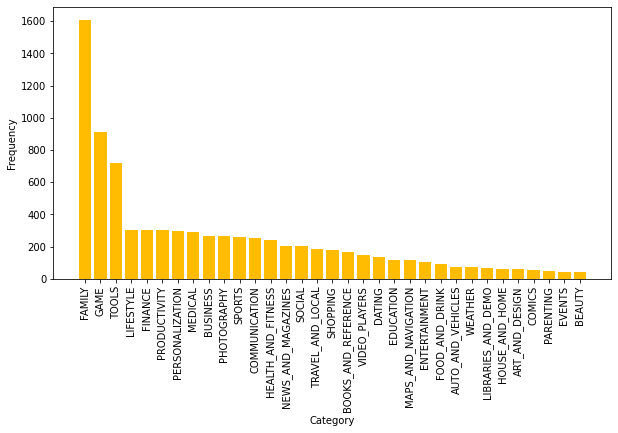

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.bar(temp.index, temp['count'], color='#ffbc00')

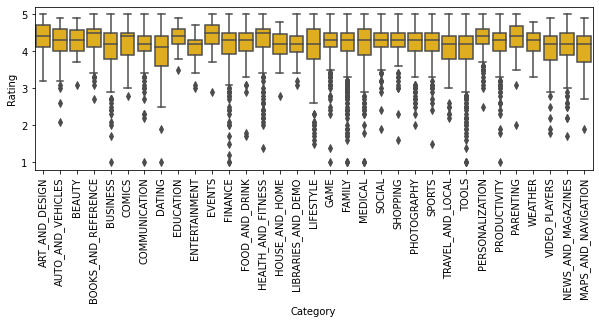

In [ ]:
plt.figure(figsize=(10,3))
plt.xticks(rotation=90)
sns.boxplot(data.Category, data.Rating, palette=['#ffbc00']*23)

In [ ]:
# Reviews 변수 nan값 없음, int로 데이터 타입 변환
data.Reviews = data.Reviews.astype(int)

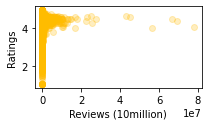

In [ ]:
plt.figure(figsize=(3,1.5))
plt.xlabel('Reviews (10million)')
plt.ylabel('Ratings')
plt.scatter(data.Reviews, data.Rating, alpha=0.25, color='#ffbc00')

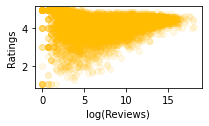

In [ ]:
# 로그 변환, Reviews 최소값이 1이라 log(x)
plt.figure(figsize=(3,1.5))
plt.xlabel('log(Reviews)')
plt.ylabel('Ratings')
plt.scatter(data.Reviews.map(lambda x: math.log(x)), data.Rating, alpha=0.1, color='#ffbc00')

In [ ]:
data.Reviews = data.Reviews.map(lambda x: math.log(x))

In [ ]:
# Size 변수는 Mb, kb 단위 혼재, Varies with device 도 있음
data[(data.App == 'iPair-Meet, Chat, Dating') | (data.App == 'Dynamics AX') | (data.App == 'Floor Plan Creator')].iloc[:,[4]]

,Size
37,Varies with device
600,77M
5783,976k


In [ ]:
# 단위 변환
data.Size = data.Size.map(lambda x: x.replace('M','000').replace('.','').replace('k',''))
data.Size[data.Size == 'Varies with device'] = data.Size[data.Size != 'Varies with device'].median()
data.Size = data.Size.astype(int)
data[(data.App == 'iPair-Meet, Chat, Dating') | (data.App == 'Dynamics AX') | (data.App == 'Floor Plan Creator')].iloc[:,[4]]

,Size
37,33000
600,77000
5783,976


(array([ 256.,   92.,  863.,  679.,  713.,  612., 1686.,  488.,  394.,
         359.,  286.,  270.,  248.,  212.,  185.,  171.,  183.,  156.,
         176.,  168.]),
 array([1.100000e+01, 5.010450e+03, 1.000990e+04, 1.500935e+04,
        2.000880e+04, 2.500825e+04, 3.000770e+04, 3.500715e+04,
        4.000660e+04, 4.500605e+04, 5.000550e+04, 5.500495e+04,
        6.000440e+04, 6.500385e+04, 7.000330e+04, 7.500275e+04,
        8.000220e+04, 8.500165e+04, 9.000110e+04, 9.500055e+04,
        1.000000e+05]),
 <a list of 20 Patch objects>)

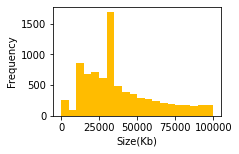

In [ ]:
plt.figure(figsize=(3,2))
plt.xlabel('Size(Kb)')
plt.ylabel('Frequency')
plt.hist(data.Size, bins=20, color='#ffbc00')

In [ ]:
data.Installs.unique()

array(['10,000+', '500,000+', '5,000,000+', '50,000,000+', '100,000+',
       '50,000+', '1,000,000+', '10,000,000+', '5,000+', '100,000,000+',
       '1,000,000,000+', '1,000+', '500,000,000+', '100+', '500+', '10+',
       '5+', '50+', '1+'], dtype=object)

In [ ]:
# Installs 변수는 nan 값 없음, 이상치 없음, 수치형이나 범주형으로 표현된 변수
data.Installs = data.Installs.map(lambda x: x.replace(',','').replace('+','')).astype(int)

In [ ]:
data.Installs.unique()

array([     10000,     500000,    5000000,   50000000,     100000,
            50000,    1000000,   10000000,       5000,  100000000,
       1000000000,       1000,  500000000,        100,        500,
               10,          5,         50,          1])

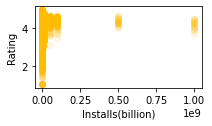

In [ ]:
plt.figure(figsize=(3,1.5))
plt.xlabel('Installs(billion)')
plt.ylabel('Rating')
plt.scatter(data.Installs, data.Rating, alpha=0.1, color='#ffbc00')

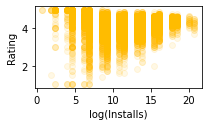

In [ ]:
plt.figure(figsize=(3,1.5))
plt.xlabel('log(Installs)')
plt.ylabel('Rating')
plt.scatter(data.Installs.map(lambda x: math.log(x+1)), data.Rating, alpha=0.1, color='#ffbc00')

In [ ]:
data.Installs = data.Installs.map(lambda x: math.log(x))

In [ ]:
# Type 변수는 결측치 1건 있었으나 Rating nan 값 없애면서 없어짐, Free or Paid
temp = data.iloc[:,[0,2,6]].groupby(['Type','Rating']).count().unstack()
temp = temp.fillna(0).astype(int)
temp.columns = temp.columns.map(lambda x: x[1])
temp

,1.0,1.2,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0
Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Free,14,1,3,3,4,7,7,12,11,8,14,18,17,19,22,21,37,40,73,65,61,95,116,146,157,213,267,343,492,591,754,848,826,782,607,392,185,79,243
Paid,2,0,0,0,0,1,1,0,1,0,0,2,2,1,2,2,3,5,8,4,2,5,10,10,10,11,19,16,21,30,56,49,69,66,76,50,36,6,28


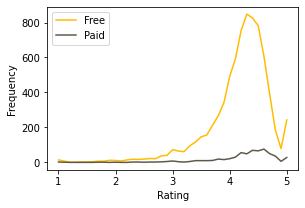

In [ ]:
plt.figure(figsize=(4.5,3))
plt.plot(temp.columns, temp.iloc[0], color='#ffbc00')
plt.plot(temp.columns, temp.iloc[1], color='#60584c')
plt.legend(temp.index)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [ ]:
data = pd.concat([data, pd.get_dummies(data.Type)], axis=1)

In [ ]:
data.Price.unique()

array(['0', '$4.99', '$3.99', '$6.99', '$7.99', '$5.99', '$2.99', '$3.49',
       '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49', '$10.00',
       '$24.99', '$11.99', '$79.99', '$16.99', '$14.99', '$29.99',
       '$12.99', '$2.49', '$10.99', '$1.50', '$19.99', '$15.99', '$33.99',
       '$39.99', '$3.95', '$4.49', '$1.70', '$8.99', '$1.49', '$3.88',
       '$399.99', '$17.99', '$400.00', '$3.02', '$1.76', '$4.84', '$4.77',
       '$1.61', '$2.50', '$1.59', '$6.49', '$1.29', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$8.49', '$1.75', '$14.00', '$2.00',
       '$3.08', '$2.59', '$19.40', '$3.90', '$4.59', '$15.46', '$3.04',
       '$13.99', '$4.29', '$3.28', '$4.60', '$1.00', '$2.95', '$2.90',
       '$1.97', '$2.56', '$1.20'], dtype=object)

In [ ]:
data.Price = data.Price.map(lambda x: x.replace('$','')).astype(float)

In [ ]:
data.Price.unique()

array([  0.  ,   4.99,   3.99,   6.99,   7.99,   5.99,   2.99,   3.49,
         1.99,   9.99,   7.49,   0.99,   9.  ,   5.49,  10.  ,  24.99,
        11.99,  79.99,  16.99,  14.99,  29.99,  12.99,   2.49,  10.99,
         1.5 ,  19.99,  15.99,  33.99,  39.99,   3.95,   4.49,   1.7 ,
         8.99,   1.49,   3.88, 399.99,  17.99, 400.  ,   3.02,   1.76,
         4.84,   4.77,   1.61,   2.5 ,   1.59,   6.49,   1.29, 299.99,
       379.99,  37.99,  18.99, 389.99,   8.49,   1.75,  14.  ,   2.  ,
         3.08,   2.59,  19.4 ,   3.9 ,   4.59,  15.46,   3.04,  13.99,
         4.29,   3.28,   4.6 ,   1.  ,   2.95,   2.9 ,   1.97,   2.56,
         1.2 ])

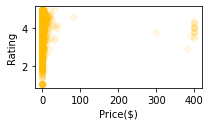

In [ ]:
plt.figure(figsize=(3,1.5))
plt.xlabel('Price($)')
plt.ylabel('Rating')
plt.scatter(data.Price, data.Rating, alpha=0.1, color='#ffbc00')

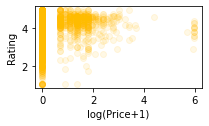

In [ ]:
plt.figure(figsize=(3,1.5))
plt.xlabel('log(Price+1)')
plt.ylabel('Rating')
plt.scatter(data.Price.map(lambda x: math.log(x+1)), data.Rating, alpha=0.1, color='#ffbc00')

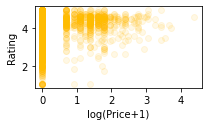

In [ ]:
# Price 변수 이상치 삭제, 로그 변환
data = data.drop(data[data.Price > 250].index)
plt.figure(figsize=(3,1.5))
plt.xlabel('log(Price+1)')
plt.ylabel('Rating')
plt.scatter(data.Price.map(lambda x: math.log(x+1)), data.Rating, alpha=0.1, color='#ffbc00')
data.Price = data.Price.map(lambda x: math.log(x+1))

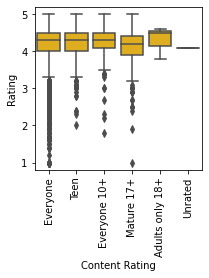

In [ ]:
# Content Rating 분포 확인
plt.figure(figsize=(3,3))
plt.xticks(rotation=90)
sns.boxplot(data['Content Rating'], data.Rating, palette=['#ffbc00']*6)

In [ ]:
# Content Rating 변수 이상치 삭제
data = data.drop(data[data['Content Rating'] == 'Unrated'].index)
data[data['Content Rating'] == 'Unrated']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,ART_AND_DESIGN,AUTO_AND_VEHICLES,BEAUTY,BOOKS_AND_REFERENCE,BUSINESS,COMICS,COMMUNICATION,DATING,EDUCATION,ENTERTAINMENT,EVENTS,FAMILY,FINANCE,FOOD_AND_DRINK,GAME,HEALTH_AND_FITNESS,HOUSE_AND_HOME,LIBRARIES_AND_DEMO,LIFESTYLE,MAPS_AND_NAVIGATION,MEDICAL,NEWS_AND_MAGAZINES,PARENTING,PERSONALIZATION,PHOTOGRAPHY,PRODUCTIVITY,SHOPPING,SOCIAL,SPORTS,TOOLS,TRAVEL_AND_LOCAL,VIDEO_PLAYERS,WEATHER,Free,Paid


In [ ]:
data = pd.concat([data, pd.get_dummies(data['Content Rating'])], axis=1)

In [ ]:
# Genres 변수 제1정규화, 더미 변수
temp = data.Genres.str.split(';')
t = pd.DataFrame(temp.map(lambda x: x[0]))
t = t.append(pd.DataFrame(temp[temp.map(lambda x: len(x) > 1)].map(lambda x: x[1])))
t['App'], t['count'] = data['App'], 1
t = t.groupby(['Genres','App']).count().unstack(level=0)
t.columns = t.columns.map(lambda x: x[1])
data.set_index(['App'], inplace=True)
for i in t.columns:
  data[i] = t[i]
  data[i] = data[i].fillna(0).astype(int)
data.loc[:,['Art & Design', 'Pretend Play', 'Creativity']].head()

,Art & Design,Pretend Play,Creativity
App,,,
Photo Editor & Candy Camera & Grid & ScrapBook,1,0,0
Coloring book moana,1,1,0
"U Launcher Lite – FREE Live Cool Themes, Hide Apps",1,0,0
Sketch - Draw & Paint,1,0,0
Pixel Draw - Number Art Coloring Book,1,0,1


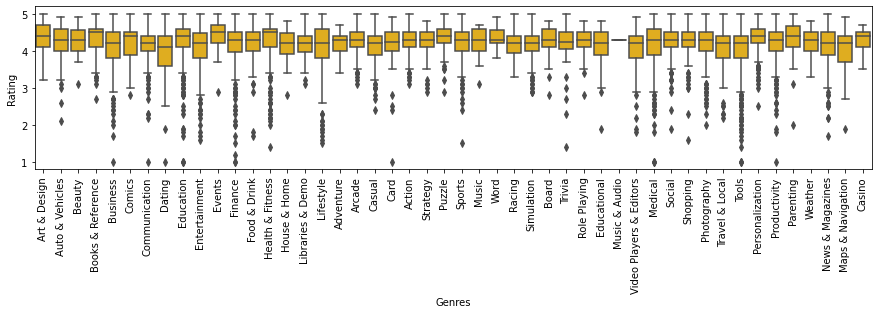

In [ ]:
plt.figure(figsize=(15,3))
plt.xticks(rotation=90)
tt = temp.map(lambda x: x[0])
tt.index = data.index
sns.boxplot(tt, data.Rating, palette=['#ffbc00']*48)

In [ ]:
# Last Updated
data['Days from Update'] = (pd.to_datetime('2020-06-18') - pd.to_datetime(data['Last Updated'])).map(lambda x: str(x)[:str(x).find(' ')]).astype(int)
data.loc[:, ['Last Updated','Days from Update']]

,Last Updated,Days from Update
App,,
Photo Editor & Candy Camera & Grid & ScrapBook,"January 7, 2018",893
Coloring book moana,"January 15, 2018",885
"U Launcher Lite – FREE Live Cool Themes, Hide Apps","August 1, 2018",687
Sketch - Draw & Paint,"June 8, 2018",741
Pixel Draw - Number Art Coloring Book,"June 20, 2018",729
...,...,...
FR Calculator,"June 18, 2017",1096
Sya9a Maroc - FR,"July 25, 2017",1059
Fr. Mike Schmitz Audio Teachings,"July 6, 2018",713


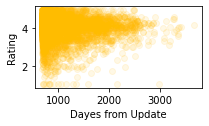

In [ ]:
plt.figure(figsize=(3,1.5))
plt.xlabel('Dayes from Update')
plt.ylabel('Rating')
plt.scatter(data['Days from Update'], data.Rating, alpha=0.1, color='#ffbc00')

In [ ]:
# Android Ver 변수, 범주형으로 두기, 더미 변수
temp = data['Android Ver'].map(lambda x: str(x)[:(str(x).find('.')+2)])
temp[(temp == 'V') | (temp == 'n')] = '4.0'
data = pd.concat([data, pd.get_dummies(temp)], axis=1)
data['Updating'] = 1
data.Updating[data['Android Ver'].map(lambda x: str(x).find('-') > 0)] = 0

(array([2.000e+00, 1.600e+01, 8.600e+01, 3.400e+01, 1.120e+02, 2.030e+02,
        7.780e+02, 2.010e+02, 8.000e+00, 3.100e+01, 3.131e+03, 1.809e+03,
        3.140e+02, 1.840e+02, 7.150e+02, 4.500e+02, 1.600e+01, 4.200e+01,
        4.100e+01, 8.000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <a list of 20 Patch objects>)

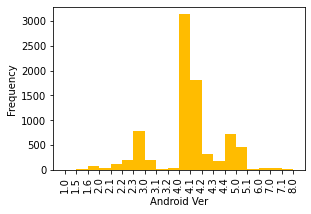

In [ ]:
plt.figure(figsize=(4.5,3))
plt.xlabel('Android Ver')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.hist(sorted(temp), bins=20, color='#ffbc00')

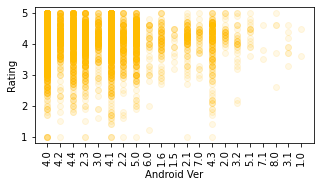

In [ ]:
plt.figure(figsize=(5,2.5))
plt.xlabel('Android Ver')
plt.ylabel('Rating')
plt.xticks(rotation=90)
plt.scatter(temp, data.Rating, alpha=0.1, color='#ffbc00')

###### 한꺼번에

In [ ]:
data = pd.read_csv('appstore.csv')

In [ ]:
# 밀린 열
temp = data.iloc[10472, 1:12]
temp.index = data.columns[2:13]
data.iloc[10472, 2:13] = temp
data.iloc[10472, 1], data.iloc[10472, 9] = 'LIFESTYLE', 'Lifestyle'

# 중복 제거
data = data.drop_duplicates(['App'], keep='first')

# Rating
data = data.drop(data[data.Rating.isna()].index)
data.Rating = data.Rating.astype(float)

# Category
data = pd.concat([data, pd.get_dummies(data.Category)], axis=1)

# Reviews
data.Reviews = data.Reviews.astype(int)
data.Reviews = data.Reviews.map(lambda x: math.log(x))

# Size
data.Size = data.Size.map(lambda x: x.replace('M','000').replace('.','').replace('k',''))
data.Size[data.Size == 'Varies with device'] = data.Size[data.Size != 'Varies with device'].median()
data.Size = data.Size.astype(int)

# Installs
data.Installs = data.Installs.map(lambda x: x.replace(',','').replace('+','')).astype(int)
data.Installs = data.Installs.map(lambda x: math.log(x))

# Type
data = pd.concat([data, pd.get_dummies(data.Type)], axis=1)

# Price
data.Price = data.Price.map(lambda x: x.replace('$','')).astype(float)
data = data.drop(data[data.Price > 250].index)
data.Price = data.Price.map(lambda x: math.log(x+1))

# Content Rating
data = data.drop(data[data['Content Rating'] == 'Unrated'].index)
data = pd.concat([data, pd.get_dummies(data['Content Rating'])], axis=1)

# Genres
temp = data.Genres.str.split(';')
t = pd.DataFrame(temp.map(lambda x: x[0]))
t = t.append(pd.DataFrame(temp[temp.map(lambda x: len(x) > 1)].map(lambda x: x[1])))
t['App'], t['count'] = data['App'], 1
t = t.groupby(['Genres','App']).count().unstack(level=0)
t.columns = t.columns.map(lambda x: x[1])
data.set_index(['App'], inplace=True)
for i in t.columns:
  data[i] = t[i]
  data[i] = data[i].fillna(0).astype(int)

# Last Updated
data['Days from Update'] = (pd.to_datetime('2020-06-18') - pd.to_datetime(data['Last Updated'])).map(lambda x: str(x)[:str(x).find(' ')]).astype(int)

# Android Ver
temp = data['Android Ver'].map(lambda x: str(x)[:(str(x).find('.')+2)])
temp[(temp == 'V') | (temp == 'n')] = '4.0'
data = pd.concat([data, pd.get_dummies(temp)], axis=1)
data['Updating'] = 1
data.Updating[data['Android Ver'].map(lambda x: str(x).find('-') > 0)] = 0

###### 모델링

In [ ]:
# X, y 나누기
train = data.drop(['Category','Rating','Type','Content Rating','Genres','Last Updated','Current Ver','Android Ver'], axis=1)
test = data.Rating

In [ ]:
score = 0
kf = KFold(n_splits=3, random_state=2020)
for train_index, valid_index in kf.split(train):
  train_X, train_y = train.iloc[train_index], test[train_index]
  valid_X, valid_y = train.iloc[valid_index], test[valid_index]
  
  model = LinearRegression().fit(train_X, train_y)
    
  pred = model.predict(valid_X)
  pred[pred < 1] = 1.0
  pred[pred > 5] = 5.0
  score += metrics.mean_squared_error(valid_y, pred)/3

In [ ]:
#mae
score

0.3594523771702236

In [ ]:
#mse
score

0.2597908662769356

In [ ]:
score = 0
kf = KFold(n_splits=3, random_state=2020)
for train_index, valid_index in kf.split(train):
  train_X, train_y = train.iloc[train_index], test[train_index]
  valid_X, valid_y = train.iloc[valid_index], test[valid_index]
  
  model = lgb.LGBMRegressor(n_estimators=25000)
  model.fit(train_X, train_y, 
            eval_set=(valid_X, valid_y), 
            eval_metric='l2',
            early_stopping_rounds=5000, 
            verbose=25000)
    
  pred = model.predict(valid_X)
  score += metrics.mean_squared_error(valid_y, pred)/3

Training until validation scores don't improve for 5000 rounds.
Early stopping, best iteration is:
[50]	valid_0's l2: 0.133365	valid_0's l2: 0.133365
Training until validation scores don't improve for 5000 rounds.
Early stopping, best iteration is:
[49]	valid_0's l2: 0.289559	valid_0's l2: 0.289559
Training until validation scores don't improve for 5000 rounds.
Early stopping, best iteration is:
[20]	valid_0's l2: 0.339037	valid_0's l2: 0.339037


In [ ]:
#mae
score

0.34977530850441896

In [ ]:
#mse
score

0.2539871107941873

In [ ]:
atv = ELU(alpha=1.0)
model = Sequential()
model.add(Dense(units=120, activation=atv, input_dim=120))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=16, activation=atv))
model.add(Dense(units=8, activation=atv))
model.add(Dense(units=1, activation='linear'))
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

score = 0
kf = KFold(n_splits=3, random_state=2020)
for train_index, valid_index in kf.split(train):
  train_X, train_y = train.iloc[train_index], test[train_index]
  valid_X, valid_y = train.iloc[valid_index], test[valid_index]
    
  model.fit(train_X, train_y, epochs=2000, batch_size=25000, validation_data=(valid_X, valid_y), verbose=0)
    
  pred = model.predict(valid_X)
  pred[pred < 1] = 1
  pred[pred > 5] = 5
  score += metrics.mean_absolute_error(valid_y, pred)/3

In [ ]:
#mae
score

0.6796749738299924

In [ ]:
atv = ELU(alpha=1.0)
model = Sequential()
model.add(Dense(units=120, activation=atv, input_dim=120))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=16, activation=atv))
model.add(Dense(units=8, activation=atv))
model.add(Dense(units=1, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

score = 0
kf = KFold(n_splits=3, random_state=2020)
for train_index, valid_index in kf.split(train):
  train_X, train_y = train.iloc[train_index], test[train_index]
  valid_X, valid_y = train.iloc[valid_index], test[valid_index]
    
  model.fit(train_X, train_y, epochs=2000, batch_size=25000, validation_data=(valid_X, valid_y), verbose=0)
    
  pred = model.predict(valid_X)
  pred[pred < 1] = 1
  pred[pred > 5] = 5
  score += metrics.mean_squared_error(valid_y, pred)/3

In [ ]:
#mse
score

0.37766186755911757

Text(0.384, 1.75, '0.359')

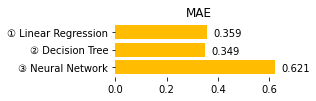

In [ ]:
plt.figure(figsize=(3,1))
plt.title('MAE')
plt.barh(['③ Neural Network','② Decision Tree','① Linear Regression'],[0.621, 0.349, 0.359], color='#ffbc00')
plt.box(False)
plt.text(0.621+0.025, -0.25, '0.621')
plt.text(0.349+0.025, 0.75, '0.349')
plt.text(0.359+0.025, 1.75, '0.359')

Text(0.28400000000000003, 1.75, '0.259')

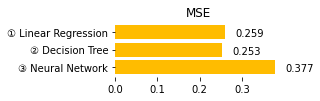

In [ ]:
plt.figure(figsize=(3,1))
plt.title('MSE')
plt.barh(['③ Neural Network','② Decision Tree','① Linear Regression'],[0.377, 0.253, 0.259], color='#ffbc00')
plt.box(False)
plt.text(0.377+0.025, -0.25, '0.377')
plt.text(0.253+0.025, 0.75, '0.253')
plt.text(0.259+0.025, 1.75, '0.259')

###### 최적화

In [ ]:
score = 0
kf = KFold(n_splits=3, shuffle=True, random_state=2020)
for train_index, valid_index in kf.split(train):
  train_X, train_y = train.iloc[train_index], test[train_index]
  valid_X, valid_y = train.iloc[valid_index], test[valid_index]
  
  model = lgb.LGBMRegressor(n_estimators=25000,
                            num_leaves=900,
                            learning_rate=0.03,
                            colsample_bytree=0.3,
                            reg_alpha=2,
                            reg_lambda=49)
  model.fit(train_X, train_y, 
            eval_set=(valid_X, valid_y), 
            eval_metric='l1',
            early_stopping_rounds=5000, 
            verbose=25000)
    
  pred = model.predict(valid_X)
  score += metrics.mean_absolute_error(valid_y, pred)/3

Training until validation scores don't improve for 5000 rounds.
Early stopping, best iteration is:
[423]	valid_0's l2: 0.241716	valid_0's l1: 0.344918
Training until validation scores don't improve for 5000 rounds.
Early stopping, best iteration is:
[501]	valid_0's l2: 0.261266	valid_0's l1: 0.349509
Training until validation scores don't improve for 5000 rounds.
Early stopping, best iteration is:
[653]	valid_0's l2: 0.240555	valid_0's l1: 0.341961


In [ ]:
# mae
score

0.3454626206812669

In [ ]:
score = 0
kf = KFold(n_splits=3, shuffle=True, random_state=2020)
for train_index, valid_index in kf.split(train):
  train_X, train_y = train.iloc[train_index], test[train_index]
  valid_X, valid_y = train.iloc[valid_index], test[valid_index]
  
  model = lgb.LGBMRegressor(n_estimators=25000,
                            num_leaves=900,
                            learning_rate=0.03,
                            colsample_bytree=0.3,
                            reg_alpha=2,
                            reg_lambda=49)
  model.fit(train_X, train_y, 
            eval_set=(valid_X, valid_y), 
            eval_metric='l2',
            early_stopping_rounds=5000, 
            verbose=25000)
    
  pred = model.predict(valid_X)
  score += metrics.mean_squared_error(valid_y, pred)/3

Training until validation scores don't improve for 5000 rounds.
Early stopping, best iteration is:
[423]	valid_0's l2: 0.241716	valid_0's l2: 0.241716
Training until validation scores don't improve for 5000 rounds.
Early stopping, best iteration is:
[501]	valid_0's l2: 0.261266	valid_0's l2: 0.261266
Training until validation scores don't improve for 5000 rounds.
Early stopping, best iteration is:
[653]	valid_0's l2: 0.240555	valid_0's l2: 0.240555


In [ ]:
# mse
score

0.24784562807123306

Text(0.374, 2.75, '0.349')

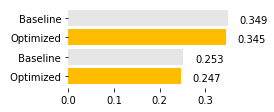

In [ ]:
plt.figure(figsize=(3,1.5))
plt.barh([' Optimized',' Baseline','Optimized','Baseline'],[0.247, 0.2523, 0.345, 0.349], color=['#ffbc00','#e6e6e6','#ffbc00','#e6e6e6'])
plt.box(False)
plt.text(0.247+0.025, -0.25, '0.247')
plt.text(0.253+0.025, 0.75, '0.253')
plt.text(0.345+0.025, 1.75, '0.345')
plt.text(0.349+0.025, 2.75, '0.349')

In [ ]:
atv = ELU(alpha=3.0)
model = Sequential()
model.add(Dense(units=120, activation=atv, input_dim=120))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=64, activation=atv))
model.add(Dense(units=16, activation=atv))
model.add(Dense(units=1, activation='linear'))
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

score = 0
kf = KFold(n_splits=3, shuffle=True, random_state=2020)
for train_index, valid_index in kf.split(train):
  train_X, train_y = train.iloc[train_index], test[train_index]
  valid_X, valid_y = train.iloc[valid_index], test[valid_index]
    
  model.fit(train_X, train_y, epochs=2000, batch_size=25000, validation_data=(valid_X, valid_y), verbose=0)
    
  pred = model.predict(valid_X)
  pred[pred < 1] = 1
  pred[pred > 5] = 5
  score += metrics.mean_absolute_error(valid_y, pred)/3

In [ ]:
# mae
score

0.36996589949043296

In [ ]:
atv = ELU(alpha=3.0)
model = Sequential()
model.add(Dense(units=120, activation=atv, input_dim=120))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=64, activation=atv))
model.add(Dense(units=16, activation=atv))
model.add(Dense(units=1, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

score = 0
kf = KFold(n_splits=3, shuffle=True, random_state=2020)
for train_index, valid_index in kf.split(train):
  train_X, train_y = train.iloc[train_index], test[train_index]
  valid_X, valid_y = train.iloc[valid_index], test[valid_index]
    
  model.fit(train_X, train_y, epochs=2000, batch_size=25000, validation_data=(valid_X, valid_y), verbose=0)
    
  pred = model.predict(valid_X)
  pred[pred < 1] = 1
  pred[pred > 5] = 5
  score += metrics.mean_squared_error(valid_y, pred)/3

In [ ]:
# mse
score

0.3571828275302837

Text(0.646, 2.75, '0.621')

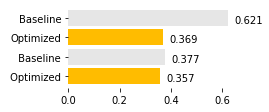

In [ ]:
plt.figure(figsize=(3,1.5))
plt.barh([' Optimized',' Baseline','Optimized','Baseline'],[0.357, 0.377, 0.369, 0.621], color=['#ffbc00','#e6e6e6','#ffbc00','#e6e6e6'])
plt.box(False)
plt.text(0.357+0.025, -0.25, '0.357')
plt.text(0.377+0.025, 0.75, '0.377')
plt.text(0.369+0.025, 1.75, '0.369')
plt.text(0.621+0.025, 2.75, '0.621')

###### 앙상블

In [ ]:
  model = LinearRegression().fit(train_X, train_y)
    
  pred1 = model.predict(valid_X)
  pred1[pred < 1] = 1.0
  pred1[pred > 5] = 5.0

In [ ]:
  model = lgb.LGBMRegressor(n_estimators=25000,
                            num_leaves=900,
                            learning_rate=0.03,
                            colsample_bytree=0.3,
                            reg_alpha=2,
                            reg_lambda=49)
  model.fit(train_X, train_y, 
            eval_set=(valid_X, valid_y), 
            eval_metric='l1',
            early_stopping_rounds=5000, 
            verbose=25000)
    
  pred2 = model.predict(valid_X)

Training until validation scores don't improve for 5000 rounds.
Early stopping, best iteration is:
[653]	valid_0's l2: 0.240555	valid_0's l1: 0.341961


In [ ]:
atv = ELU(alpha=3.0)
model = Sequential()
model.add(Dense(units=120, activation=atv, input_dim=120))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=64, activation=atv))
model.add(Dense(units=16, activation=atv))
model.add(Dense(units=1, activation='linear'))
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

model.fit(train_X, train_y, epochs=2000, batch_size=25000, validation_data=(valid_X, valid_y), verbose=0)
    
pred3 = model.predict(valid_X)
pred3[pred < 1] = 1
pred3[pred > 5] = 5

In [ ]:
print(metrics.mean_absolute_error(valid_y, pred1))
print(metrics.mean_absolute_error(valid_y, pred2))
pred3 = [x for y in pred3 for x in y]
print(metrics.mean_absolute_error(valid_y, pred3))
print(metrics.mean_absolute_error(valid_y, (pred1+pred2+pred3)/3))

0.3392974393953571
0.34196106444711005
0.36248465329244717
0.33311320131128586


Text(0.36400000000000005, 2.75, '0.339')

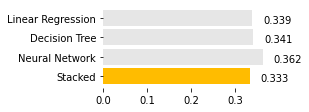

In [ ]:
plt.figure(figsize=(3,1.5))
plt.barh(['Stacked','Neural Network','Decision Tree','Linear Regression'],[0.333,0.362,0.341,0.339], color=['#ffbc00','#e6e6e6','#e6e6e6','#e6e6e6'])
plt.box(False)
plt.text(0.333+0.025, -0.25, '0.333')
plt.text(0.362+0.025, 0.75, '0.362')
plt.text(0.341+0.025, 1.75, '0.341')
plt.text(0.339+0.025, 2.75, '0.339')

In [ ]:
  model = lgb.LGBMRegressor(n_estimators=25000,
                            num_leaves=900,
                            learning_rate=0.03,
                            colsample_bytree=0.3,
                            reg_alpha=2,
                            reg_lambda=49)
  model.fit(train_X, train_y, 
            eval_set=(valid_X, valid_y), 
            eval_metric='l2',
            early_stopping_rounds=5000, 
            verbose=25000)
    
  pred2 = model.predict(valid_X)

Training until validation scores don't improve for 5000 rounds.
Early stopping, best iteration is:
[653]	valid_0's l2: 0.240555	valid_0's l2: 0.240555


In [ ]:
atv = ELU(alpha=3.0)
model = Sequential()
model.add(Dense(units=120, activation=atv, input_dim=120))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=128, activation=atv))
model.add(Dense(units=64, activation=atv))
model.add(Dense(units=16, activation=atv))
model.add(Dense(units=1, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

model.fit(train_X, train_y, epochs=2000, batch_size=25000, validation_data=(valid_X, valid_y), verbose=0)
    
pred3 = model.predict(valid_X)
pred3[pred < 1] = 1
pred3[pred > 5] = 5

In [ ]:
print(metrics.mean_squared_error(valid_y, pred1))
print(metrics.mean_squared_error(valid_y, pred2))
pred3 = [x for y in pred3 for x in y]
print(metrics.mean_squared_error(valid_y, pred3))
print(metrics.mean_squared_error(valid_y, (pred1+pred2+pred3)/3))

0.24014336938830033
0.24055495289930556
0.2779317244072464
0.2381135854466412


Text(0.265, 2.75, '0.240')

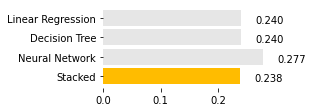

In [ ]:
plt.figure(figsize=(3,1.5))
plt.barh(['Stacked','Neural Network','Decision Tree','Linear Regression'],[0.238,0.277,0.240,0.240], color=['#ffbc00','#e6e6e6','#e6e6e6','#e6e6e6'])
plt.box(False)
plt.text(0.238+0.025, -0.25, '0.238')
plt.text(0.277+0.025, 0.75, '0.277')
plt.text(0.240+0.025, 1.75, '0.240')
plt.text(0.240+0.025, 2.75, '0.240')

In [ ]:
temp = {}
for i in range(len(train_X.columns)):
  temp[train_X.columns[i]] = model.feature_importances_[i]


In [ ]:
temp2 = sorted(temp, key=temp.get)

<BarContainer object of 120 artists>

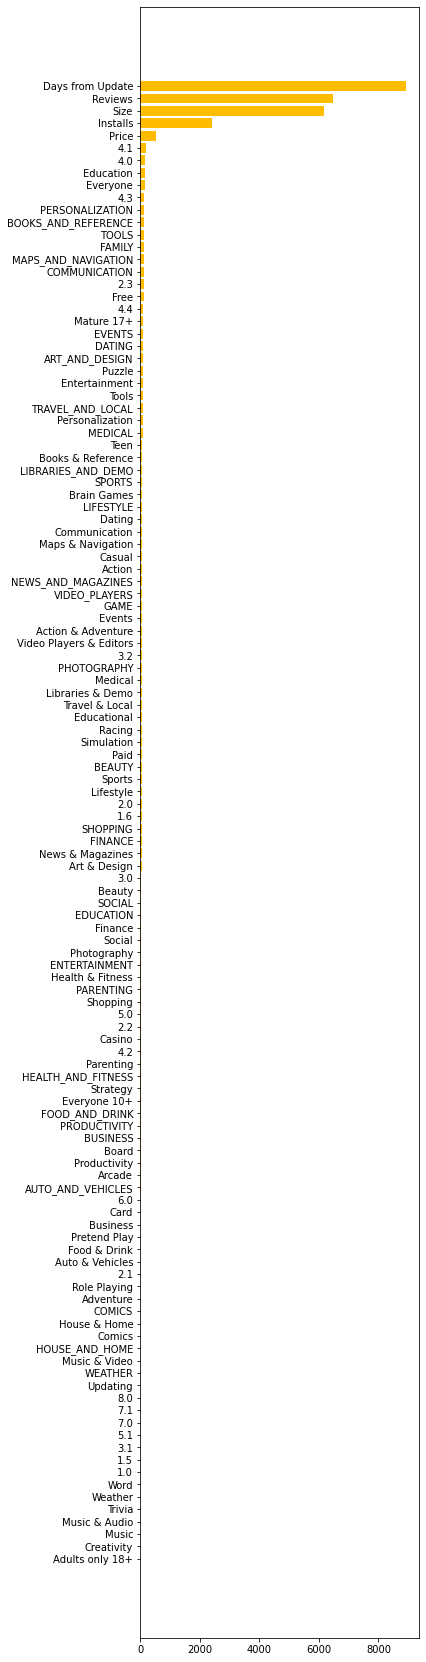

In [ ]:
plt.figure(figsize=(5,30))
plt.barh(temp2, sorted(model.feature_importances_), color='#ffbc00')

In [ ]:
model.coef_[train_X.columns == 'Price']

array([-0.0662248])

<BarContainer object of 120 artists>

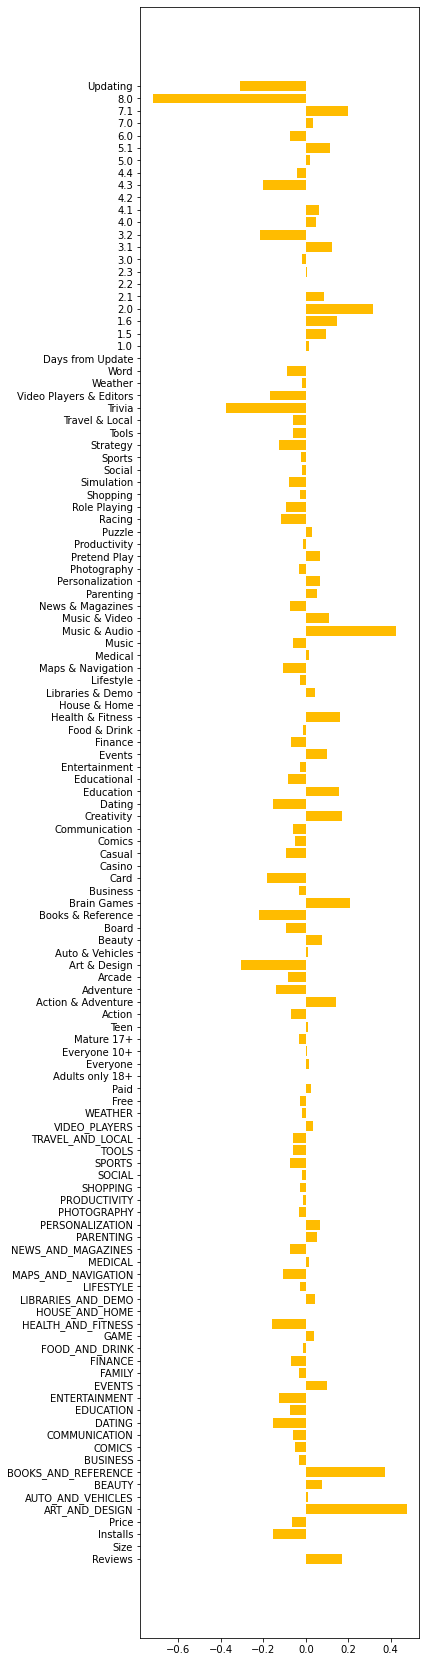

In [ ]:
plt.figure(figsize=(5,30))
plt.barh(train_X.columns, model.coef_, color='#ffbc00')

In [ ]:
#ffbc00